# データのロードと確認

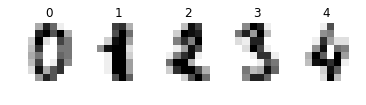

In [1]:
from sklearn import datasets
digits = datasets.load_digits()
%matplotlib inline
import matplotlib.pyplot as plt

images_number = 5
images_and_labels = list(zip(digits.images, digits.target))

for i, (image, label) in enumerate(images_and_labels[:images_number]):
    plt.subplot(2, images_number, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('%i' % label)

# 入力データの確認

In [2]:
print(digits.data[0])
print(digits.target[0])
samples_count = len(digits.images)
print("Number of samples: " + str(samples_count))

[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.   5.
   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.   0.   8.
   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.  11.   0.   1.
  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.   0.   0.   6.  13.
  10.   0.   0.   0.]
0
Number of samples: 1797


# 学習、テスト、検証データの準備

In [3]:
train_data = digits.data[: int(0.7*samples_count)]
train_labels = digits.target[: int(0.7*samples_count)]

test_data = digits.data[int(0.7*samples_count): int(0.9*samples_count)]
test_labels = digits.target[int(0.7*samples_count): int(0.9*samples_count)]

score_data = digits.data[int(0.9*samples_count): ]
score_labels = digits.target[int(0.9*samples_count): ]

print("Number of training records: " + str(len(train_data)))
print("Number of testing records : " + str(len(test_data)))
print("Number of scoring records : " + str(len(score_data)))

Number of training records: 1257
Number of testing records : 360
Number of scoring records : 180


# パイプラインの作成とモデルの学習

In [4]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import svm, metrics

scaler = preprocessing.StandardScaler()
clf = svm.SVC(kernel='rbf')
pipeline = Pipeline([('scaler', scaler), ('svc', clf)])

model = pipeline.fit(train_data, train_labels)

predicted = model.predict(test_data)
print("Evaluation report: \n\n%s" % metrics.classification_report(test_labels, predicted))

Evaluation report: 

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        37
          1       0.97      0.97      0.97        34
          2       1.00      0.97      0.99        36
          3       1.00      0.94      0.97        35
          4       0.78      0.97      0.87        37
          5       0.97      0.97      0.97        38
          6       0.97      0.86      0.91        36
          7       0.92      0.97      0.94        35
          8       0.91      0.89      0.90        35
          9       0.97      0.92      0.94        37

avg / total       0.95      0.94      0.95       360



# Watson ML管理クライアント・ライブラリの導入

In [5]:
!rm -rf $PIP_BUILD/watson-machine-learning-client
!pip install watson-machine-learning-client --upgrade

Requirement already up-to-date: watson-machine-learning-client in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: tqdm in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: urllib3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: certifi in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: tabulate in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: ibm-cos-sdk in /opt/conda/envs/DSX-Python3

# 機械学習モデルのリポジトリ登録

In [ ]:
# 資格情報取得
# 自分の環境の資格情報をコピペして下さい
wml_credentials={
  "url": "https://ibm-watson-ml.mybluemix.net",
  "username": "***",
  "password": "***",
  "instance_id": "***"
}

In [7]:
# 管理クライアントインスタンスの生成
from watson_machine_learning_client import WatsonMachineLearningAPIClient
client = WatsonMachineLearningAPIClient(wml_credentials)

In [8]:
# モデルのリポジトリ登録
published_model = client.repository.store_model(model=model, meta_props={'name':'Digits Classification Model'}, \
training_data=train_data, training_target=train_labels)

# 登録したモデルのUID取得
published_model_uid = published_model['metadata']['guid']
print(published_model_uid)

In [11]:
# リポジトリに登録済みモデルの一覧
client.repository.list_models()

------------------------------------  -----------------------  ------------------------  -----------------
GUID                                  NAME                     CREATED                   FRAMEWORK
8d105f5e-59e9-4af9-b502-e9fa6c0917c4  mnist1                   2018-04-16T23:59:05.732Z  tensorflow-1.5
a630875d-d183-4178-9cf7-4a6c79a8000b  CIFAR10                  2018-04-17T01:00:55.550Z  tensorflow-1.5
33aeec66-407e-4a31-b8c8-b599498f24e4  MNIST best model         2018-04-24T13:50:51.040Z  tensorflow-1.5
f3834096-9aeb-4e84-8844-650150514d71  Tent-Sell-Predict        2018-04-26T10:57:55.153Z  wml-1.1
8fbeb37d-9c55-4cc4-aa98-4b336e8d2e30  Digits prediction model  2018-04-26T12:10:29.729Z  scikit-learn-0.19
5028d53c-e0ad-4e02-bf01-bcacdfb226ef  Digits prediction model  2018-04-27T04:49:51.071Z  scikit-learn-0.19
------------------------------------  -----------------------  ------------------------  -----------------


# リポジトリ上のモデルをWEBサービスとしてデプロイ

In [19]:
# WEBサービス作成
created_deployment = client.deployments.create(published_model_uid, "Deployment of scikit model")

# エンドポイントURLの取得
scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
print(scoring_endpoint)



#######################################################################################

Synchronous deployment creation for uid: '53e236c6-217c-4a3d-874b-3c2cf8ed54eb' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='53e236c6-217c-4a3d-874b-3c2cf8ed54eb'
------------------------------------------------------------------------------------------------


https://ibm-watson-ml.mybluemix.net/v3/wml_instances/0f8dab2b-453e-41e6-84d4-92bfc5546426/published_models/5028d53c-e0ad-4e02-bf01-bcacdfb226ef/deployments/53e236c6-217c-4a3d-874b-3c2cf8ed54eb/online


# WEBサービスの呼出し

In [26]:
# 必要ライブラリのロード
import numpy as np
import urllib3, requests, json

# ML Tokenの取得
headers = urllib3.util.make_headers(basic_auth='{}:{}'.\
        format(wml_credentials['username'], wml_credentials['password']))
url = '{}/v3/identity/token'.format(wml_credentials['url'])
response = requests.get(url, headers=headers)
mltoken = 'Bearer ' + json.loads(response.text).get('token')

# Tokenを使ったヘッダの生成
header_token = {'Content-Type': 'application/json', 'Authorization': mltoken}

# Webサービス用パラメータの設定
payload_scoring = {"values": [list(data) for data in score_data]}

# Webサービスの呼出し
scoring = json.loads( requests.post(scoring_endpoint,json=payload_scoring, headers=header_token).text )

# 呼出し結果の取得
predict_list = np.array([item[0] for item in scoring['values']])

# 予測結果の表示
print(predict_list)

# 正解データの表示
print(score_labels)

# 正解率の表示
print("Evaluation report: \n\n%s" % metrics.classification_report(score_labels, predict_list))

[5 2 8 0 1 7 6 3 2 1 7 8 6 3 1 3 9 1 7 6 8 4 3 1 4 0 5 3 6 9 6 1 7 5 4 4 7
 2 2 5 4 3 5 8 4 5 0 8 9 8 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 5
 4 5 6 7 8 9 0 9 5 5 6 5 0 9 8 9 8 4 1 7 7 3 5 1 0 0 2 2 7 8 2 0 1 2 6 8 8
 7 5 3 4 6 6 6 4 9 1 5 0 9 5 2 8 2 0 0 1 7 6 3 2 1 7 4 6 3 1 3 9 1 7 6 8 4
 5 1 4 0 5 3 6 9 6 1 7 5 4 4 7 2 8 2 2 5 7 9 5 4 8 8 4 9 0 8 9 8]
[5 2 8 0 1 7 6 3 2 1 7 4 6 3 1 3 9 1 7 6 8 4 3 1 4 0 5 3 6 9 6 1 7 5 4 4 7
 2 2 5 7 9 5 4 4 9 0 8 9 8 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3
 4 5 6 7 8 9 0 9 5 5 6 5 0 9 8 9 8 4 1 7 7 3 5 1 0 0 2 2 7 8 2 0 1 2 6 3 3
 7 3 3 4 6 6 6 4 9 1 5 0 9 5 2 8 2 0 0 1 7 6 3 2 1 7 4 6 3 1 3 9 1 7 6 8 4
 3 1 4 0 5 3 6 9 6 1 7 5 4 4 7 2 8 2 2 5 7 9 5 4 8 8 4 9 0 8 9 8]
Evaluation report: 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        16
          1       1.00      1.00      1.00        19
          2       1.00      1.00      1.00        17
          3       0.93      0.72  